https://medium.com/tensorflow/deep-reinforcement-learning-playing-cartpole-through-asynchronous-advantage-actor-critic-a3c-7eab2eea5296

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import zmq
import multiprocessing as mp
import time
import json

from MarkovDecisionProcess import NumpyEncoder

from tensorflow.python import keras
from tensorflow.python.keras import layers

plt.xkcd()

In [2]:
np.log(0.51)

-0.6733445532637656

## XOR Classifier

In [2]:
input_data = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])

output_data = np.array([
    [0],
    [1],
    [1],
    [0]
])

annot = np.array([
    [0.25, 0.25],
    [0.25, 0.75],
    [0.75, 0.25],
    [0.75, 0.75]
])

[0 0] [0]
[0 1] [1]
[1 0] [1]
[1 1] [0]



/home/nathan/.conda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


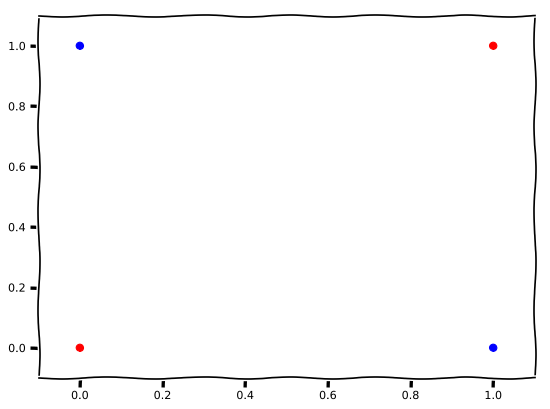

In [3]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)

for x, y, a in zip(input_data, output_data, annot):
    print(x, y)
    color = 'b' if y else 'r'
    plt.plot(*x, color + 'o')
    
print()

In [4]:
class Classifier(keras.Model):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size

        self.dense = layers.Dense(100, activation='relu')
        self.probs = layers.Dense(output_size)

    def call(self, inputs):
        x = self.dense(inputs)
        return self.probs(x)

## Testing the Classifier

In [5]:
model = Classifier(2, 1)

In [6]:
tensor = tf.convert_to_tensor(input_data, dtype=tf.float32)
output = model(tensor)

NameError: name 'tf' is not defined

In [7]:
output - output_data

NameError: name 'output' is not defined

In [8]:
grids = []

lin = np.linspace(0,1,21)
input_grid = []
for x in lin:
    for y in lin:
        input_grid.append([x, y])

lr = 0.1
losses = []
for i in range(100):
    tensor = tf.convert_to_tensor(input_data, dtype=tf.float32)
    with tf.GradientTape() as tape:
        output = model(tensor)
        loss = -tf.reduce_mean((output_data - output)**2)

    losses.append(loss.numpy())
    grads = tape.gradient(loss, model.trainable_weights)
    for w, g in zip(model.trainable_weights, grads):
        w.assign_add(lr*g)
    
    tensor = tf.convert_to_tensor(input_grid, dtype=tf.float32)
    output = model(tensor).numpy()
    grids.append(output)

NameError: name 'tf' is not defined

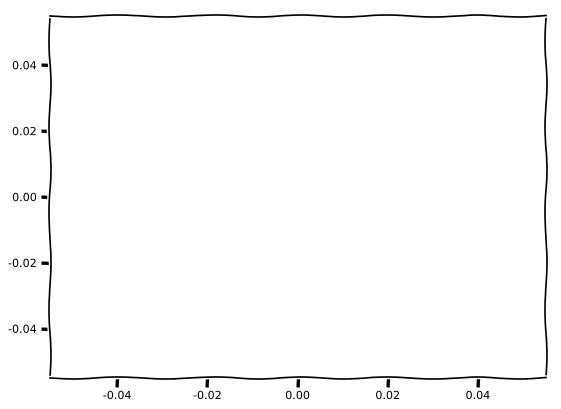

In [9]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.abs(losses))
plt.show()

In [10]:
x1, x2 = np.split(np.array(input_grid), 2, axis=1)
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(x1, x2, 100*np.ones_like(y), c=grids[-1])
plt.show()

IndexError: list index out of range

<Figure size 640x480 with 0 Axes>

In [11]:
tensor = tf.convert_to_tensor(input_data, dtype=tf.float32)
output = model(tensor).numpy()

NameError: name 'tf' is not defined

In [12]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

for x, y, a in zip(input_data, output, annot):
    print(x, y)
    color = 'b' if y > 0.5 else 'r'
    plt.plot(*x, color + 'o')
    
print()

NameError: name 'output' is not defined

<Figure size 640x480 with 0 Axes>

## Testing Multiprocessing

In [13]:
def simple_test(name):
    np.random.seed(name)
    sleep_time = np.random.randint(0,5)
    print(name, sleep_time)
    time.sleep(sleep_time)
    print(name, "done!")

In [14]:
processes = [mp.Process(target=simple_test, args=(i,)) for i in range(4)]

In [15]:
for p in processes:
    p.start()

0 4
1 3
2 0
2 done!
3 2
3 done!
1 done!
0 done!


In [16]:
for p in processes:
    p.join()

## Sending Data Between Multiple Processes Using ZMQ

In [17]:
def master_model():
    header = "master >"
    context = zmq.Context()
    with context.socket(zmq.REP) as socket:
        socket.bind('tcp://127.0.0.1:5555')
        print(header, 'listening...')
        while True:
            msg = json.loads(socket.recv())
            time.sleep(1)
            print(header, msg)
            if 'kill' in msg and msg['kill'] == True:
                print(header, "exiting")
                socket.send_string(json.dumps({ "exited": True, "name": "master" }, cls=NumpyEncoder))
                break
            socket.send_string(json.dumps({ "received": True, "data": np.random.rand(2,3)}, cls=NumpyEncoder))

In [18]:
def slave_model(name):
    header = "- {} >".format(name)
    context = zmq.Context()
    with context.socket(zmq.REQ) as socket:
        socket.connect('tcp://127.0.0.1:5555')
        socket.send_string(json.dumps({ "name": name }, cls=NumpyEncoder))
        msg = json.loads(socket.recv())
        print(header, msg)

In [19]:
slave_count = 4
master = mp.Process(target=master_model)
processes = [mp.Process(target=slave_model, args=(i,)) for i in range(slave_count)]

In [20]:
master.start()

master > listening...
master > {'name': 0}
master > {'name': 3}
master > {'name': 1}
master > {'name': 2}
master > {'kill': True}
master > exiting


In [21]:
for p in processes:
    p.start()

- 0 > {'received': True, 'data': [[0.045646679248979916, 0.2933831152468196, 0.7319241938702756], [0.8510412338521891, 0.09891798820667064, 0.6804364974248827]]}
- 3 > {'received': True, 'data': [[0.9161114202483361, 0.11988216353853343, 0.9257604512643629], [0.6617291634900276, 0.9222341071074717, 0.08412563362510439]]}
- 1 > {'received': True, 'data': [[0.12425720100241322, 0.5952691063473975, 0.1504720549248877], [0.10133300764940811, 0.12348131662341999, 0.46636059437599975]]}
- 2 > {'received': True, 'data': [[0.28291403176956975, 0.3108705053926022, 0.6388901674335132], [0.5534965879725087, 0.7950737436188912, 0.2922305540930802]]}


In [22]:
context = zmq.Context()
with context.socket(zmq.REQ) as socket:
    socket.connect('tcp://127.0.0.1:5555')
    socket.send_json({ "kill": True })
    msg = json.loads(socket.recv())
    print(msg)

{'exited': True, 'name': 'master'}


In [23]:
master.join()
for p in processes:
    p.join()

## Multiple Tensorflow Processes

In [5]:
def start_master():
    import tensorflow as tf
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    tf.enable_eager_execution(config=config)

    header = "master >"
    context = zmq.Context()
    model = Classifier(2, 1)
    losses = []

    def get_loss(model):
        tensor = tf.convert_to_tensor(input_data, dtype=tf.float32)
        output = model(tensor)
        loss = -tf.reduce_mean((output_data - output)**2)
        return np.abs(loss.numpy())
        
    def apply_grads(model, grads):
        for w, g in zip(model.trainable_weights, grads):
            w.assign_add(g)

    with context.socket(zmq.REP) as socket:
        socket.bind('tcp://127.0.0.1:5555')
        print(header, 'listening...')
        try:
            count = 0
            while True:
                msg = json.loads(socket.recv())
                socket.send_string(json.dumps({ "weights": model.get_weights()}, cls=NumpyEncoder))
                apply_grads(model, msg['grads'])
                loss = get_loss(model)
                losses.append(loss)
                count += 1
                if count % 100 == 0:
                    print("{} {:03d} {}".format(header, count, loss))
        except KeyboardInterrupt as e:
            print(header, 'Stopped.')
            plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
            plt.plot(np.abs(losses))
            plt.show()

In [6]:
def start_worker(input_data, output_data):
    import tensorflow as tf
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    tf.enable_eager_execution(config=config)

    header = "- {} >".format(input_data)
    context = zmq.Context()
    
    model = Classifier(2, 1)
    losses = []
    lr = 0.01
    input_data = input_data
    output_data = output_data
    tensor = tf.convert_to_tensor(np.array([input_data]), dtype=tf.float32)
    
    def get_grads(model, tensor):
        with tf.GradientTape() as tape:
            output = model(tensor)
            loss = -tf.reduce_mean((output_data - output)**2)
        losses.append(loss.numpy())
        grads = tape.gradient(loss, model.trainable_weights)
        return [lr*g.numpy() for g in grads]
    
    try:
        for i in range(100):
            with context.socket(zmq.REQ) as socket:
                socket.connect('tcp://127.0.0.1:5555')
                grads = get_grads(model, tensor)
                socket.send_string(json.dumps({ "grads": grads, "data": input_data }, cls=NumpyEncoder))
                msg = json.loads(socket.recv())
                model.set_weights(msg['weights'])
    except KeyboardInterrupt as e:
        print(header, 'Stopped.')

In [7]:
slave_count = 4
master = mp.Process(target=start_master)
processes = [mp.Process(target=start_worker, args=(input_data[i], output_data[i])) for i in range(slave_count)]

master > listening...
master > 100 0.166836678981781
master > 200 0.11089776456356049
master > 300 0.07343021035194397
master > 400 0.04666896536946297
master > Stopped.


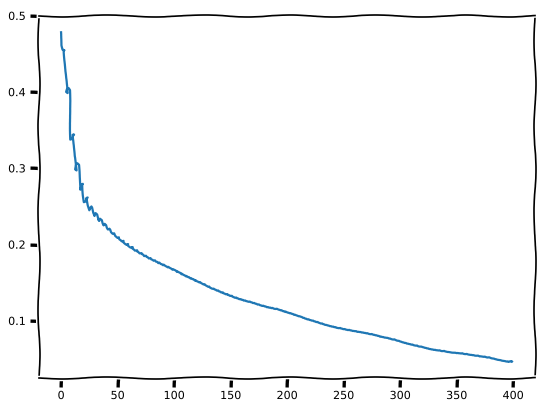

In [8]:
master.start()

In [9]:
for p in processes:
    p.start()

In [10]:
master.join()
for p in processes:
    p.join()